In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Example: Load OHLC data (or replace with your data)
# Use yfinance or your broker's API to get actual data
# df = pd.read_csv('your_ohlc_data.csv')  # Must have 'Open', 'High', 'Low', 'Close' columns

from tvDatafeed import TvDatafeed,Interval


tv = TvDatafeed()
nifty_data=tv.get_hist('NIFTY','NSE',interval=Interval.in_5_minute,n_bars=5000)

df=nifty_data.copy()
df=df.tail(1500)
df = df.rename(columns={'open':'Open','high': 'High','low': 'Low','close': 'Close','volume': 'Volume'})
df['Datetime']=df.index
df.set_index('Datetime', inplace=True)


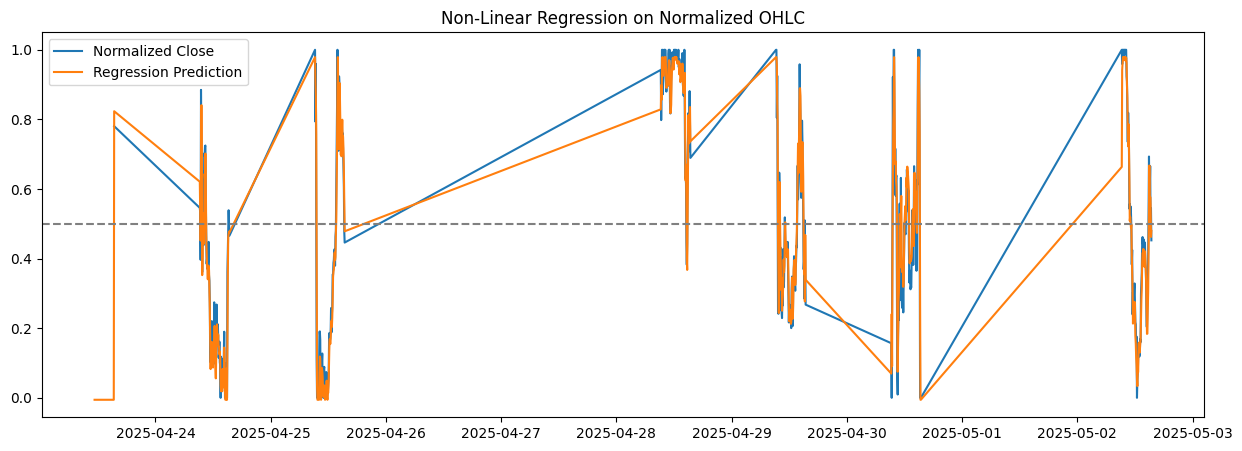

In [5]:

window = 50

# Normalize in a rolling window
def normalize(series, window):
    min_val = series.rolling(window).min()
    max_val = series.rolling(window).max()
    return (series - min_val) / (max_val - min_val + 1e-6)

# Combine normalized OHLC
df['Open_norm'] = normalize(df['Open'], window)
df['High_norm'] = normalize(df['High'], window)
df['Low_norm']  = normalize(df['Low'], window)
df['Close_norm'] = normalize(df['Close'], window)

# Feature vector (X) and target (y)
X = df[['Open_norm', 'High_norm', 'Low_norm']].fillna(0).values
y = df['Close_norm'].fillna(0).values

# Initialize weights
w = np.random.rand(X.shape[1])
b = 0
lr = 0.01
epochs = 1000

# Gradient Descent
for epoch in range(epochs):
    y_pred = X @ w + b
    error = y_pred - y
    dw = X.T @ error / len(X)
    db = np.sum(error) / len(X)

    w -= lr * dw
    b -= lr * db

# Final prediction
df['Pred'] = X @ w + b

# Detect crossovers with midline (0.5)
df['Signal'] = np.where((df['Pred'].shift(1) < 0.5) & (df['Pred'] > 0.5), 'Buy',
                 np.where((df['Pred'].shift(1) > 0.5) & (df['Pred'] < 0.5), 'Sell', None))

# Plot
plt.figure(figsize=(15, 5))
plt.plot(df['Close_norm'], label='Normalized Close')
plt.plot(df['Pred'], label='Regression Prediction')
plt.axhline(0.5, color='gray', linestyle='--')
plt.legend()
plt.title('Non-Linear Regression on Normalized OHLC')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go

# Load your intraday data (ensure 'Datetime', 'Open', 'High', 'Low', 'Close', 'Volume' columns)
# df = pd.read_csv('your_5min_data.csv', parse_dates=['Datetime'])

# Normalize over rolling window
def normalize(series, window):
    min_val = series.rolling(window).min()
    max_val = series.rolling(window).max()
    return (series - min_val) / (max_val - min_val + 1e-6)

# Add normalized columns
df['Open_norm'] = normalize(df['Open'], window)
df['High_norm'] = normalize(df['High'], window)
df['Low_norm'] = normalize(df['Low'], window)
df['Close_norm'] = normalize(df['Close'], window)
df['Volume_norm'] = normalize(df['Volume'], window)

# Feature matrix
X = df[['Open_norm', 'High_norm', 'Low_norm', 'Volume_norm']].fillna(0).values
y = df['Close_norm'].fillna(0).values

# Gradient Descent Setup
w = np.random.rand(X.shape[1])
b = 0
lr = 0.01
epochs = 1000

# Training loop
for _ in range(epochs):
    y_pred = X @ w + b
    error = y_pred - y
    dw = X.T @ error / len(X)
    db = np.sum(error) / len(X)
    w -= lr * dw
    b -= lr * db

# Prediction and signal
df['Pred'] = X @ w + b
df['Signal'] = np.where((df['Pred'].shift(1) < 0.5) & (df['Pred'] > 0.5), 'Buy',
                 np.where((df['Pred'].shift(1) > 0.5) & (df['Pred'] < 0.5), 'Sell', None))

# Plot using Plotly with intraday gaps removed
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df['Close_norm'], mode='lines', name='Normalized Close'))
fig.add_trace(go.Scatter(x=df.index, y=df['Pred'], mode='lines', name='Regression Prediction'))
fig.add_trace(go.Scatter(x=df.index, y=[0.5]*len(df), mode='lines', name='Midline (0.5)', line=dict(dash='dot')))

# Buy/Sell markers
buy = df[df['Signal'] == 'Buy']
sell = df[df['Signal'] == 'Sell']
fig.add_trace(go.Scatter(x=buy.index, y=buy['Pred'], mode='markers', name='Buy',
                         marker=dict(color='green', size=8, symbol='triangle-up')))
fig.add_trace(go.Scatter(x=sell.index, y=sell['Pred'], mode='markers', name='Sell',
                         marker=dict(color='red', size=8, symbol='triangle-down')))

# Intraday session gap removal
fig.update_layout(
    title='Intraday Regression with Signals',
    xaxis_title='Time',
    yaxis_title='Normalized Price',
    xaxis=dict(
        rangebreaks=[
            dict(bounds=["sat", "mon"]),
            dict(bounds=[16, 9.25], pattern="hour")  # change to your market hours
        ]
    ),
    template='plotly_dark',
    height=600
)

fig.show()


In [24]:

window = 20  # rolling normalization window

# Normalize function
def normalize(series, window):
    min_val = series.rolling(window).min()
    max_val = series.rolling(window).max()
    return (series - min_val) / (max_val - min_val + 1e-6)

# Normalize price and volume
df['Open_norm'] = normalize(df['Open'], window)
df['High_norm'] = normalize(df['High'], window)
df['Low_norm'] = normalize(df['Low'], window)
df['Close_norm'] = normalize(df['Close'], window)
df['Volume_norm'] = normalize(df['Volume'], window)

# Feature matrix: Open, High, Low, Volume (not Close — that's our target)
X = df[['Open_norm', 'High_norm', 'Low_norm', 'Volume_norm']].fillna(0).values
y = df['Close_norm'].fillna(0).values

# Regression using Gradient Descent
w = np.random.rand(X.shape[1])
b = 0
lr = 0.01
epochs = 1000

for _ in range(epochs):
    y_pred = X @ w + b
    error = y_pred - y
    dw = X.T @ error / len(X)
    db = np.sum(error) / len(X)
    w -= lr * dw
    b -= lr * db

# Store prediction
df['Pred'] = X @ w + b

# Denormalize prediction using rolling min/max of Close
close_min = df['Close'].rolling(window).min()
close_max = df['Close'].rolling(window).max()
df['Pred_denorm'] = df['Pred'] * (close_max - close_min + 1e-6) + close_min

df['Predicted_Close'] = df['Pred_denorm']

# Generate signals (crossing midline 0.5)
df['Signal'] = np.where((df['Pred'].shift(1) < 0.5) & (df['Pred'] > 0.5), 'Buy',
                        np.where((df['Pred'].shift(1) > 0.5) & (df['Pred'] < 0.5), 'Sell', None))

# Prepare candlestick + regression + signal chart
fig = go.Figure()

# ✅ Candlestick chart
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['Open'],
    high=df['High'],
    low=df['Low'],
    close=df['Close'],
    name='Candles',
    increasing_line_color='green',
    decreasing_line_color='red',
    showlegend=True
))

# ✅ Add regression prediction (scaled back using normalized Close range if you want to compare visually)
# fig.add_trace(go.Scatter(
#     x=df.index,
#     y=df['Pred'], 
#     mode='lines',
#     name='Regression Prediction',
#     line=dict(color='orange', width=1)
# ))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Pred_denorm'],
    mode='lines',
    name='Regression Prediction',
    line=dict(color='orange', width=1)
))


# ✅ Buy/Sell markers
buy = df[df['Signal'] == 'Buy']
sell = df[df['Signal'] == 'Sell']

fig.add_trace(go.Scatter(
    x=buy.index,
    y=buy['Low'] * 0.995,  # a bit below candle low
    mode='markers',
    name='Buy',
    marker=dict(color='lime', symbol='triangle-up', size=10)
))

fig.add_trace(go.Scatter(
    x=sell.index,
    y=sell['High'] * 1.005,  # a bit above candle high
    mode='markers',
    name='Sell',
    marker=dict(color='red', symbol='triangle-down', size=10)
))

# ✅ Remove gaps for weekends & non-trading hours
fig.update_layout(
    title='5-Min Intraday Candlestick with Regression Prediction & Signals',
    xaxis_title='Time',
    yaxis_title='Price',
    xaxis=dict(
        rangebreaks=[
            dict(bounds=["sat", "mon"]),  # remove weekends
            dict(bounds=[15.30, 9.15], pattern="hour")  # adjust to your market (NSE is 09:15–15:30)
        ]
    ),
    template='plotly_dark',
    height=700
)

fig.show()

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Denormalize Close and Predictions for fair comparison
close_min = df['Close'].rolling(window).min()
close_max = df['Close'].rolling(window).max()
df['Pred_denorm'] = df['Pred'] * (close_max - close_min + 1e-6) + close_min
df['Close_denorm'] = df['Close_norm'] * (close_max - close_min + 1e-6) + close_min

# Drop NaNs caused by rolling window
valid = df[['Pred_denorm', 'Close_denorm']].dropna()

# Metrics
mse = mean_squared_error(valid['Close_denorm'], valid['Pred_denorm'])
mae = mean_absolute_error(valid['Close_denorm'], valid['Pred_denorm'])
r2 = r2_score(valid['Close_denorm'], valid['Pred_denorm'])

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Squared Error (MSE): 276.7568
Mean Absolute Error (MAE): 10.8787
R-squared (R²): 0.9995


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your data
# df = pd.read_csv("your_5min_data.csv", parse_dates=['Datetime'])
# df.set_index('Datetime', inplace=True)

window = 20

# Normalize with rolling window
def normalize(series, window):
    min_val = series.rolling(window).min()
    max_val = series.rolling(window).max()
    return (series - min_val) / (max_val - min_val + 1e-6)

# Apply normalization
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[f'{col}_norm'] = normalize(df[col], window)

# Drop NaNs from rolling normalization
df.dropna(inplace=True)

# Define features and target
X = df[['Open_norm', 'High_norm', 'Low_norm', 'Volume_norm']].values
y = df['Close_norm'].values

# Chronological split: 80% train, 20% test
split_index = int(len(df) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
df_train, df_test = df.iloc[:split_index], df.iloc[split_index:]

# Train model on training data
w = np.random.rand(X_train.shape[1])
b = 0
lr = 0.01
epochs = 1000

for _ in range(epochs):
    y_pred_train = X_train @ w + b
    error = y_pred_train - y_train
    dw = X_train.T @ error / len(X_train)
    db = np.sum(error) / len(X_train)
    w -= lr * dw
    b -= lr * db

# Predict on both sets
df_train['Pred_norm'] = X_train @ w + b
df_test['Pred_norm'] = X_test @ w + b

# Denormalize
for d in [df_train, df_test]:
    close_min = d['Close'].rolling(window).min()
    close_max = d['Close'].rolling(window).max()
    d['Close_denorm'] = d['Close_norm'] * (close_max - close_min + 1e-6) + close_min
    d['Pred_denorm'] = d['Pred_norm'] * (close_max - close_min + 1e-6) + close_min



# Drop NaNs again after denormalization
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# Evaluate
def evaluate(true, pred, label=""):
    mse = mean_squared_error(true, pred)
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"\n📈 {label} Set Evaluation:")
    print(f"  - Mean Squared Error (MSE): {mse:.2f}")
    print(f"  - Mean Absolute Error (MAE): {mae:.2f}")
    print(f"  - R-squared (R²): {r2:.4f}")

evaluate(df_train['Close_denorm'], df_train['Pred_denorm'], label="Train")
evaluate(df_test['Close_denorm'], df_test['Pred_denorm'], label="Test")



📈 Train Set Evaluation:
  - Mean Squared Error (MSE): 393.66
  - Mean Absolute Error (MAE): 13.39
  - R-squared (R²): 0.9992

📈 Test Set Evaluation:
  - Mean Squared Error (MSE): 224.05
  - Mean Absolute Error (MAE): 10.17
  - R-squared (R²): 0.9359


C:\Users\Mahesh\AppData\Local\Temp\ipykernel_18168\1328261018.py:49: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Mahesh\AppData\Local\Temp\ipykernel_18168\1328261018.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Mahesh\AppData\Local\Temp\ipykernel_18168\1328261018.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

C:\Users\Mahesh\AppData\Local\Temp\ipykernel_18168\3187678951.py:21: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\Mahesh\AppData\Local\Temp\ipykernel_18168\3187678951.py:21: SettingWithCopyWarning:


A value is trying to be set on 

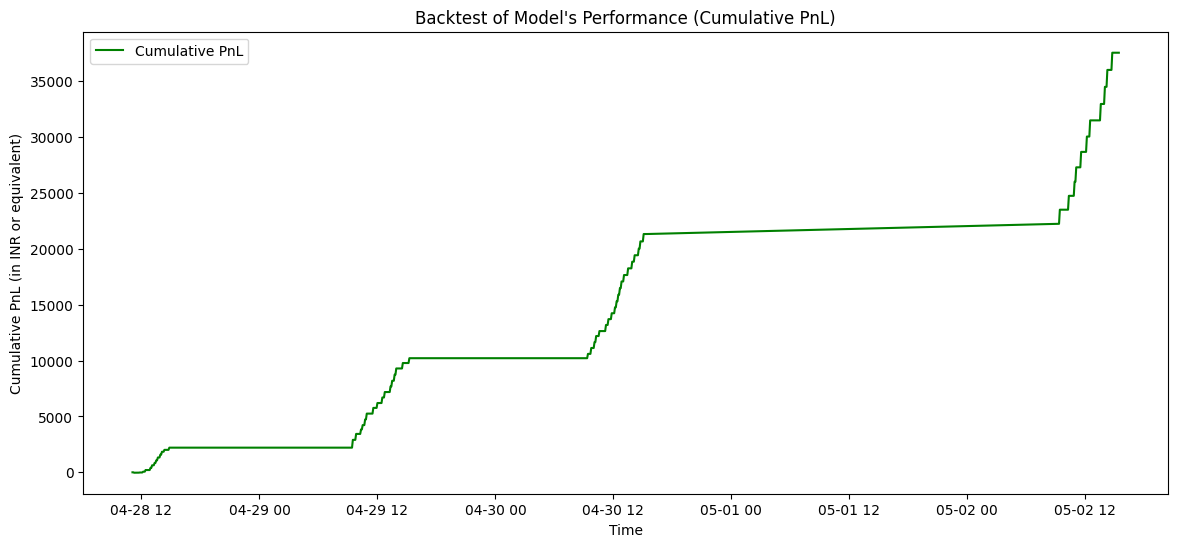


Total Cumulative PnL: ₹37560.12
Final Cash Position: ₹0.00


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_test has the denormalized predicted and actual close prices

# Initialize variables for PnL tracking
initial_cash = 100000  # Assume starting with 100,000 in capital
cash = initial_cash  # Cash left
position = 0  # Current position (0 means no position, 1 means holding)

# Track the profit/loss over time
df_test['PnL'] = 0  # Column to store daily PnL (profit/loss)

# Backtesting: Buy and Sell based on predicted price
for i in range(1, len(df_test)):
    # Buy signal: if predicted price is greater than actual price (we expect price to go up)
    if df_test['Pred_denorm'].iloc[i] > df_test['Close_denorm'].iloc[i] and position == 0:
        position = cash / df_test['Close_denorm'].iloc[i]  # Buy as much as possible with available cash
        cash = 0  # Cash is used up
        df_test['PnL'].iloc[i] = 0  # No immediate PnL on buying

    # Sell signal: if predicted price is less than actual price (expecting price to go down)
    elif df_test['Pred_denorm'].iloc[i] < df_test['Close_denorm'].iloc[i] and position > 0:
        cash = position * df_test['Close_denorm'].iloc[i]  # Sell all holdings
        position = 0  # No position after selling
        df_test['PnL'].iloc[i] = cash - initial_cash  # Calculate profit/loss from the sale

# Cumulative PnL (cumulative returns over time)
df_test['Cumulative_PnL'] = df_test['PnL'].cumsum()

# Plot the cumulative PnL over time
plt.figure(figsize=(14,6))
plt.plot(df_test.index, df_test['Cumulative_PnL'], label="Cumulative PnL", color='g')
plt.title("Backtest of Model's Performance (Cumulative PnL)")
plt.xlabel("Time")
plt.ylabel("Cumulative PnL (in INR or equivalent)")
plt.legend()
plt.show()

# Final PnL and other metrics
final_pnl = df_test['Cumulative_PnL'].iloc[-1]
print(f"\nTotal Cumulative PnL: ₹{final_pnl:.2f}")
print(f"Final Cash Position: ₹{cash:.2f}")


Starting Portfolio Value: 100000
Ending Portfolio Value: 100000.0


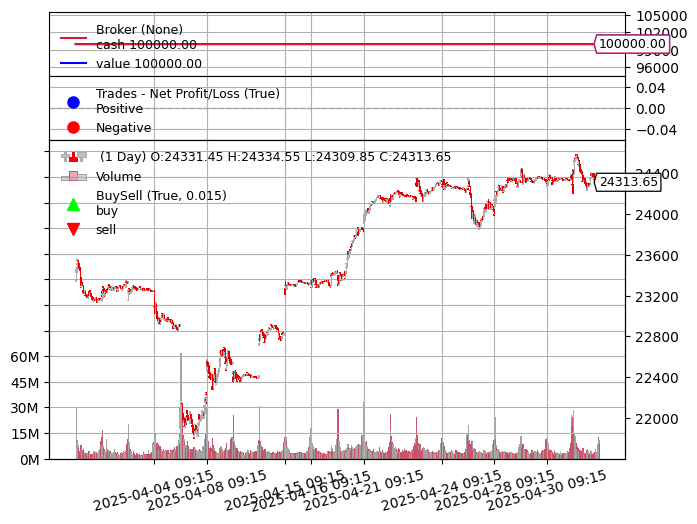

[[<Figure size 640x480 with 4 Axes>]]

In [ ]:
%matplotlib inline

import backtrader as bt
import pandas as pd

class ModelStrategy(bt.Strategy):
    # Define parameters
    cash = 100000
    position = 0
    buy_price = 0
    stop_loss_pct = 0.02  # Example stop-loss of 2% for risk management
    
    def __init__(self):
        # Add indicators and data feeds
        self.predicted_close = self.datas[0].close  # Use the predicted price as the trading signal

    def next(self):
        # Buy signal
        if self.predicted_close[0] > self.data.close[0] and self.position == 0:
            # We buy when predicted price is higher than the current price
            self.position = self.cash / self.data.close[0]  # Buy as much as possible with available cash
            self.buy_price = self.data.close[0]
            self.buy(size=self.position)
            print(f"Buy at {self.data.close[0]}")
        
        # Sell signal
        elif self.predicted_close[0] < self.data.close[0] and self.position > 0:
            # We sell when predicted price is lower than the current price
            self.position = 0
            self.sell(size=self.position)
            print(f"Sell at {self.data.close[0]}")
        
        # Check for stop-loss
        if self.position > 0 and (self.data.close[0] <= self.buy_price * (1 - self.stop_loss_pct)):
            # If price drops more than stop-loss percentage, sell
            self.position = 0
            self.sell(size=self.position)
            print(f"Stop-Loss Triggered, Sell at {self.data.close[0]}")
            

# Load your 5-minute data into a Pandas DataFrame
# df = pd.read_csv("your_5min_data.csv", parse_dates=['Datetime'], index_col='Datetime')


# df=nifty_data.copy()
# df=df.tail(1500)
# df = df.rename(columns={'open':'Open','high': 'High','low': 'Low','close': 'Close','volume': 'Volume'})
# df['Datetime']=df.index
# df.set_index('Datetime', inplace=True)




# # Assuming you have your model's predicted values in a 'Predicted_Close' column
# df['Predicted_Close'] = model_predictions  # Add your predicted values here
# df['Predicted_Close'] =
# Create a Backtrader data feed from the DataFrame
data = bt.feeds.PandasData(dataname=df)

# Create a Backtrader Cerebro engine and add the strategy and data
cerebro = bt.Cerebro()
cerebro.addstrategy(ModelStrategy)  # Add your custom strategy here
cerebro.adddata(data)  # Add your data to the engine

# Set up broker (capital, commission, etc.)
cerebro.broker.set_cash(100000)  # Initial cash
# cerebro.broker.set_commission(commission=0.001)  # 0.1% commission per trade
# cerebro.broker.set_slippage_perc(0.001)  # Add 0.1% slippage to simulate real-world conditions

# Print the starting cash
print(f"Starting Portfolio Value: {cerebro.broker.get_value()}")

# Run the backtest
cerebro.run()

# Print the final cash after backtest
print(f"Ending Portfolio Value: {cerebro.broker.get_value()}")

# Plot the results

cerebro.plot(iplot=False,style='candlestick')


In [33]:

cerebro.plot(style='candlestick')


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

In [28]:
%matplotlib inline

In [35]:
df=nifty_data.copy()
df=df.tail(1500)
df = df.rename(columns={'open':'Open','high': 'High','low': 'Low','close': 'Close','volume': 'Volume'})
df['Datetime']=df.index
df.set_index('Datetime', inplace=True)


In [36]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Simulated intraday data (replace this with actual NIFTY 5-min data)
# np.random.seed(42)
# minutes_per_day = 75
# days = 10
# total_rows = minutes_per_day * days
# dates = pd.date_range(start="2023-01-01 09:15", periods=total_rows, freq='5min')
# df = pd.DataFrame(index=dates)
# df['Open'] = np.random.normal(24000, 50, total_rows)
# df['High'] = df['Open'] + np.random.normal(10, 5, total_rows)
# df['Low'] = df['Open'] - np.random.normal(10, 5, total_rows)
# df['Close'] = df['Open'] + np.random.normal(0, 10, total_rows)
# df['Volume'] = np.random.randint(1000, 10000, total_rows)
# df = df.between_time("09:15", "15:25")

# Parameters
window = 20
rolling_window = 100
future_return_horizon = 3
volatility_window = 20
volume_threshold = 2000

# Normalize
def normalize(series, window):
    min_val = series.rolling(window).min()
    max_val = series.rolling(window).max()
    return (series - min_val) / (max_val - min_val + 1e-6)

for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[f'{col}_norm'] = normalize(df[col], window)

df.dropna(inplace=True)

# Train regression model
X = df[['Open_norm', 'High_norm', 'Low_norm', 'Volume_norm']].values
y = df['Close_norm'].values
model = LinearRegression()
model.fit(X, y)
df['Predicted_Close_norm'] = model.predict(X)

# Denormalize predicted close
close_min = df['Close'].rolling(window).min()
close_max = df['Close'].rolling(window).max()
df['Predicted_Close'] = df['Predicted_Close_norm'] * (close_max - close_min + 1e-6) + close_min

# Calculate prediction delta and rolling percentile
df['Pred_Delta'] = df['Predicted_Close'] - df['Close']
df['Delta_Percentile'] = df['Pred_Delta'].rolling(rolling_window).apply(lambda x: pd.Series(x).rank(pct=True).iloc[-1])

# Future return labeling
df['Future_Close'] = df['Close'].shift(-future_return_horizon)
df['Future_Return'] = (df['Future_Close'] - df['Close']) / df['Close']

# Volatility filter
df['Volatility'] = df['Close'].rolling(volatility_window).std()

# Filter for top 30% predicted deltas with liquidity and volatility thresholds
df_filtered = df[
    (df['Delta_Percentile'] >= 0.7) &
    (df['Volume'] > volume_threshold) &
    (df['Volatility'] > df['Volatility'].median())
].copy()

df_filtered.dropna(subset=['Future_Return'], inplace=True)

# Strategy performance stats
win_rate = (df_filtered['Future_Return'] > 0).mean()
avg_return = df_filtered['Future_Return'].mean()
std_return = df_filtered['Future_Return'].std()
max_drawdown = (df_filtered['Future_Return'].cumsum().cummax() - df_filtered['Future_Return'].cumsum()).max()

# Output
print(f"📊 Selected Entries: {len(df_filtered)}")
print(f"✅ Win Rate: {win_rate:.2%}")
print(f"📈 Average Future Return: {avg_return:.4f}")
print(f"📉 Std Dev of Returns: {std_return:.4f}")
print(f"💥 Max Drawdown (cumulative approx): {max_drawdown:.4f}")


📊 Selected Entries: 235
✅ Win Rate: 58.30%
📈 Average Future Return: 0.0004
📉 Std Dev of Returns: 0.0028
💥 Max Drawdown (cumulative approx): 0.0406


In [40]:
import pandas as pd
import numpy as np
import backtrader as bt
from sklearn.linear_model import LinearRegression
from datetime import time

# # Simulate 5-minute intraday data (replace with your actual data)
# np.random.seed(42)
# minutes_per_day = 75
# days = 10
# total_rows = minutes_per_day * days
# dates = pd.date_range(start="2023-01-01 09:15", periods=total_rows, freq='5min')
# df = pd.DataFrame(index=dates)
# df['Open'] = np.random.normal(24000, 50, total_rows)
# df['High'] = df['Open'] + np.random.normal(10, 5, total_rows)
# df['Low'] = df['Open'] - np.random.normal(10, 5, total_rows)
# df['Close'] = df['Open'] + np.random.normal(0, 10, total_rows)
# df['Volume'] = np.random.randint(1000, 10000, total_rows)
# df = df.between_time("09:15", "15:25")
df=nifty_data.copy()
df=df.tail(1500)
df = df.rename(columns={'open':'Open','high': 'High','low': 'Low','close': 'Close','volume': 'Volume'})
df['Datetime']=df.index
df.set_index('Datetime', inplace=True)

# Parameters
window = 20
future_horizon = 3  # Predict 6 bars ahead

# Normalize
def normalize(series, window):
    min_val = series.rolling(window).min()
    max_val = series.rolling(window).max()
    return (series - min_val) / (max_val - min_val + 1e-6)


# Step 1: Calculate future close
df['Future_Close'] = df['Close'].shift(-future_horizon)

# Step 2: Normalize features and target
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df[f'{col}_norm'] = normalize(df[col], window)

# Now normalize target
df['Future_Close_norm'] = normalize(df['Future_Close'], window)

# Step 3: Drop NaNs after all rolling + shifting
df.dropna(inplace=True)

# Step 4: Train
X = df[['Open_norm', 'High_norm', 'Low_norm', 'Volume_norm']].values
y = df['Future_Close_norm'].values


model = LinearRegression()
model.fit(X, y)
df['Predicted_Future_Close_norm'] = model.predict(X)

# Denormalize predictions
close_min = df['Close'].rolling(window).min()
close_max = df['Close'].rolling(window).max()
df['Predicted_Future_Close'] = df['Predicted_Future_Close_norm'] * (close_max - close_min + 1e-6) + close_min

# ATR
df['H-L'] = df['High'] - df['Low']
df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()

# Expected return & signal
df['Expected_Return'] = df['Predicted_Future_Close'] - df['Close']
df['Strong_Signal'] = df['Expected_Return'] > 1.5 * df['ATR']
df.dropna(inplace=True)

# Backtrader integration
class PandasDataWithPrediction(bt.feeds.PandasData):
    lines = ('Predicted_Future_Close', 'ATR', 'Strong_Signal',)
    params = (('Predicted_Future_Close', -1), ('ATR', -1), ('Strong_Signal', -1),)

class ATRFilteredStrategy(bt.Strategy):
    def __init__(self):
        self.pred = self.datas[0].Predicted_Future_Close
        self.signal = self.datas[0].Strong_Signal

    def next(self):
        current_time = self.datas[0].datetime.time(0)
        if current_time == time(15, 10):
            if self.position:
                self.close()
                print(f"[{self.datas[0].datetime.datetime(0)}] 🕒 EOD SELL @ {self.data.close[0]:.2f}")
            return

        if not self.position and self.signal[0]:
            size = self.broker.getcash() // self.data.close[0]
            self.buy(size=size)
            print(f"[{self.datas[0].datetime.datetime(0)}] ✅ BUY @ {self.data.close[0]:.2f}")
        elif self.position and self.pred[0] < self.data.close[0]:
            self.close()
            print(f"[{self.datas[0].datetime.datetime(0)}] ❌ SELL @ {self.data.close[0]:.2f}")

# Run backtest
cerebro = bt.Cerebro()
data = PandasDataWithPrediction(dataname=df)
cerebro.adddata(data)
cerebro.addstrategy(ATRFilteredStrategy)
cerebro.broker.set_cash(100000)
cerebro.broker.setcommission(commission=0.001)
print(f"Starting Portfolio Value: ₹{cerebro.broker.getvalue():.2f}")
cerebro.run()
print(f"Final Portfolio Value: ₹{cerebro.broker.getvalue():.2f}")



Starting Portfolio Value: ₹100000.00
[2025-04-04 09:15:00] ✅ BUY @ 23094.45
[2025-04-04 09:30:00] ❌ SELL @ 23118.80
[2025-04-07 09:15:00] ✅ BUY @ 21888.35
[2025-04-07 11:10:00] ❌ SELL @ 21986.30
[2025-04-16 09:15:00] ✅ BUY @ 23283.65
[2025-04-16 09:20:00] ❌ SELL @ 23307.55
Final Portfolio Value: ₹100029.67


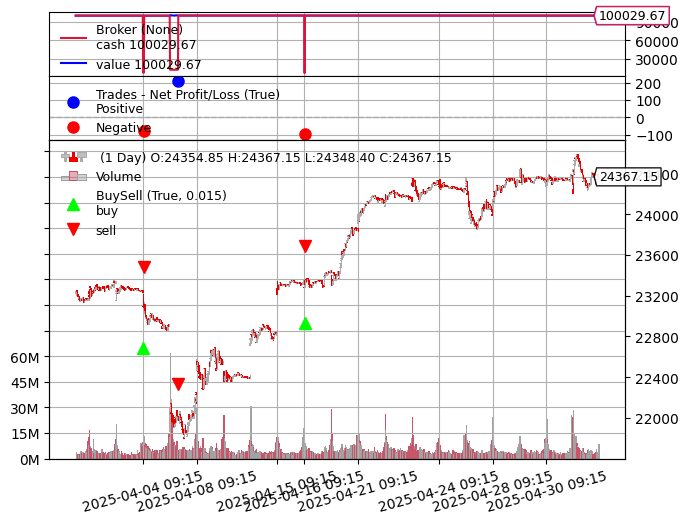

[[<Figure size 640x480 with 4 Axes>]]

In [42]:
%matplotlib inline
cerebro.plot(iplot=False,style='candlestick')
